# EDA (Exploratory Data Analysis)

This notebook performs an exploratory analysis of the dataset by following these steps:

1. **Loading the data and checking its dimensions.**
2. **Exploring the correlation structure** to understand how different features relate to each other.
3. **Examining the relationships between `topic_id` and `content_id`**, noting that there may be many-to-many mappings between them.
4. **Investigating a way to create embedding features** that could support training a text classification model to generate embeddings — beyond classification solely by topic.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Loading datasets

In [2]:
# Loading topics dataset
df_topics = pd.read_csv("./learning-equality-curriculum-recommendations/topics.csv")  
df_topics.head()

,id,title,description,channel,category,level,language,parent,has_content
0,t_00004da3a1b2,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True
1,t_000095e03056,Unit 3.3 Enlargements and Similarities,NaN,b3f329,aligned,2,en,t_aa32fb6252dc,False
2,t_00068291e9a4,Entradas e saídas de uma função,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,t_d14b6c2a2b70,True
3,t_00069b63a70a,Transcripts,NaN,6e3ba4,source,3,en,t_4054df11a74e,True
4,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 н...,Научи повече за графиките на сложните показате...,000cf7,source,4,bg,t_e2452e21d252,True


In [3]:
# Loading content dataset
df_content = pd.read_csv("./learning-equality-curriculum-recommendations/content.csv")
df_content.head()

,id,title,description,kind,text,language,copyright_holder,license
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,NaN,es,NaN,NaN
1,c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,NaN,it,NaN,NaN
2,c_0000ad142ddb,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,video,NaN,es,NaN,NaN
3,c_0000c03adc8d,Nado de aproximação,Neste vídeo você vai aprender o nado de aproxi...,document,\nNado de aproximação\nSaber nadar nas ondas ...,pt,Sikana Education,CC BY-NC-ND
4,c_00016694ea2a,geometry-m3-topic-a-overview.pdf,geometry-m3-topic-a-overview.pdf,document,Estándares Comunes del Estado de Nueva York\n\...,es,Engage NY,CC BY-NC-SA


In [4]:
# Loading the correlation dataset that relates topic_id with multiple content_ids
df_correlations = pd.read_csv("./learning-equality-curriculum-recommendations/correlations.csv")
df_correlations.head()

,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c...
1,t_00068291e9a4,c_639ea2ef9c95 c_89ce9367be10 c_ac1672cdcd2c c...
2,t_00069b63a70a,c_11a1dc0bfb99
3,t_0006d41a73a8,c_0c6473c3480d c_1c57a1316568 c_5e375cf14c47 c...
4,t_0008768bdee6,c_34e1424229b4 c_7d1a964d66d5 c_aab93ee667f4


In [5]:
# Analyzing how the corelations come
df_correlations.iloc[0,1]

'c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c_76231f9d0b5e'

In [6]:
# Checking for the dimensions of the dataset, this means that we have 76972 classes to classify
df_topics.shape, df_content.shape, df_correlations.shape

((76972, 9), (154047, 8), (61517, 2))

In [7]:
# Checking if the data is always classify the same way and how content_ids are related
df_correlations.content_ids.value_counts()

content_ids
c_dd739e116435                                                                                                                                                                                                                                     122
c_04e6b34426c6 c_4f5925b37bdf                                                                                                                                                                                                                       44
c_3856cf0f321a c_76ea3f6f2dca                                                                                                                                                                                                                       29
c_5a3c3fe31842                                                                                                                                                                                                                                      28


In [8]:
# Splitting the content_ids so we can explode the table and have one to one correlations
df_correlations['content_ids'] = df_correlations['content_ids'].str.split()
df_correlations.head()

,topic_id,content_ids
0,t_00004da3a1b2,"[c_1108dd0c7a5d, c_376c5a8eb028, c_5bc0e1e2cba..."
1,t_00068291e9a4,"[c_639ea2ef9c95, c_89ce9367be10, c_ac1672cdcd2..."
2,t_00069b63a70a,[c_11a1dc0bfb99]
3,t_0006d41a73a8,"[c_0c6473c3480d, c_1c57a1316568, c_5e375cf14c4..."
4,t_0008768bdee6,"[c_34e1424229b4, c_7d1a964d66d5, c_aab93ee667f4]"


In [9]:
# Exploting the table an having one to one correlations
df_exploded = df_correlations.explode('content_ids')

In [10]:
df_exploded.head()

,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d
0,t_00004da3a1b2,c_376c5a8eb028
0,t_00004da3a1b2,c_5bc0e1e2cba0
0,t_00004da3a1b2,c_76231f9d0b5e
1,t_00068291e9a4,c_639ea2ef9c95


In [11]:
# Amount of positive correlations between the two datasets
df_exploded.shape

(279919, 2)

In [12]:
# Checking the amount of topics correlated to content_ids
df_exploded.topic_id.value_counts()

topic_id
t_c5673d1b5642    293
t_58ca0afc0bae    270
t_92cf4e58f786    266
t_b3fa23bfbeaa    264
t_17bf2af6d82b    214
                 ... 
t_b12b3758cbfb      1
t_b12389a743a3      1
t_33b0a1de31fa      1
t_33b2302fde2c      1
t_fffe811a6da9      1
Name: count, Length: 61517, dtype: int64

In [13]:
# Checking the amount of contents correlated to topic_ids
df_exploded.content_ids.value_counts()

content_ids
c_dd739e116435    241
c_2f8849826d71     75
c_4f5925b37bdf     54
c_59778b25b537     52
c_04e6b34426c6     48
                 ... 
c_8d60dd1f3ce5      1
c_85c0be352fec      1
c_4847ffe1bb45      1
c_40f23253bd5b      1
c_92b8fad372ee      1
Name: count, Length: 154047, dtype: int64

In [14]:
# Checking the information for the most persistent content
df_exploded[df_exploded["content_ids"] == "c_dd739e116435"]

,topic_id,content_ids
626,t_02a7923ac3f1,c_dd739e116435
655,t_02bcfa7b72ec,c_dd739e116435
713,t_03005404b28a,c_dd739e116435
899,t_03ea6cb9a100,c_dd739e116435
1120,t_04df4fee08b4,c_dd739e116435
...,...,...
58950,t_f57a51a703c9,c_dd739e116435
59041,t_f5d23b7f1f25,c_dd739e116435
59119,t_f62e9925e916,c_dd739e116435
59142,t_f641783b5b66,c_dd739e116435


In [15]:
# checking the information available for that content
df_content[df_content["id"] == "c_dd739e116435"]

,id,title,description,kind,text,language,copyright_holder,license
133372,c_dd739e116435,বই,NaN,document,NaN,bn,NaN,NaN


In [16]:
# checking for some topics related to one content_id
df_topics[df_topics["id"] == "t_02a7923ac3f1"]

,id,title,description,channel,category,level,language,parent,has_content
798,t_02a7923ac3f1,নিজে করি,NaN,36068f,aligned,4,bn,t_7dcd717461b4,True


In [17]:
df_topics[df_topics["id"] == "t_f57a51a703c9"]

,id,title,description,channel,category,level,language,parent,has_content
73812,t_f57a51a703c9,"১ এর চেয়ে ছোট, ১ এর সমান এবং ১ এর চেয়ে বড় ভগ্নাংশ",NaN,36068f,aligned,4,bn,t_dce846e88e94,True


In [18]:
print(len(df_topics.language.value_counts()))
df_topics.language.value_counts()

28


language
en     36161
es     13910
pt      4177
ar      3701
fr      3701
bg      2867
sw      2860
gu      2320
bn      2176
hi      1786
it       866
zh       862
mr       300
fil      247
as       167
my       135
km       121
kn       119
te        93
or        70
ur        66
ta        60
pnb       51
pl        43
tr        40
swa       35
ru        34
mul        4
Name: count, dtype: int64

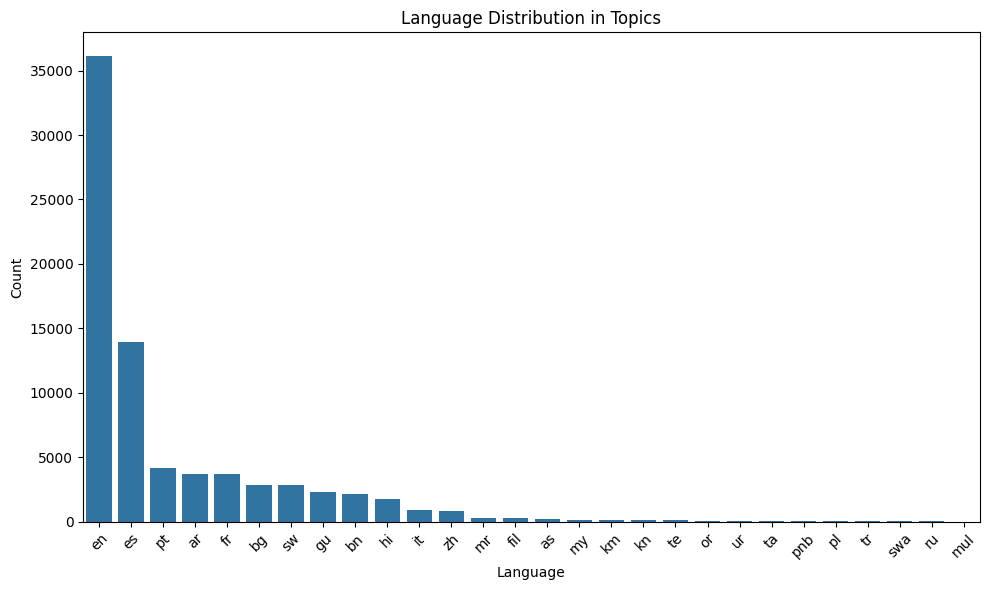

In [19]:
# Getting the data
language_counts = df_topics.language.value_counts().reset_index()
language_counts.columns = ['language', 'count']

# Plotting the graph
plt.figure(figsize=(10, 6))
sns.barplot(data=language_counts, x='language', y='count')
plt.title('Language Distribution in Topics')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Since the amount of language is only 28, we can use this as class for an blstm model that can let us have embeddings, this is going to be done in 2_blstm_and_classifier.ipynb